In [1]:
### 드라이브를 마운트합니다.
from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
### 실습에 필요한 패키지들을 로드합니다.
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import glob
import os

device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
### 데이터가 들어있는 zip파일을 압축해제 합니다.
import zipfile
path = "/content/gdrive/My Drive/"

### folder에 cat-and-dog.zip 파일이 있는 폴더의 경로를 입력해 주세요.
folder = "colab/cat_dog_example"

file_path = path+folder+"/"
if os.path.exists(file_path+"data"):
  print("파일이 이미 존재합니다.")
else:
  with zipfile.ZipFile(file_path+"cat-and-dog.zip", "r") as z:
    z.extractall(file_path+"data")
    print("압축 해제 성공")

파일이 이미 존재합니다.


In [0]:
##하이퍼 파라미터 설정
batch_size = 100 
epochs = 30
lr = 0.001

print_every = 50
save_every = 5

In [0]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, data_dir, mode, transform=None):
    self.data = sorted(glob.glob(data_dir+mode+"/*/*"))
    self.transform = transform
  
  def __getitem__(self, index):
    ## 아이템 반환 구현
    data_path = self.data[index]
    img = Image.open(data_path)
    if self.transform is not None:
      img = self.transform(img)

    ## cat은 0으로 dot은 1로 라벨링
    if os.path.basename(data_path).startswith("cat"):
        label=0
    elif os.path.basename(data_path).startswith("dog"):
        label=1    

    return img, label

  def __len__(self):
    lth = len(self.data)
    return lth


In [0]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(120),  
    transforms.RandomRotation(10), 
    transforms.RandomHorizontalFlip(p=0.5),                         
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_test = transforms.Compose([
    transforms.Resize([120, 120]),                            
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [0]:
train_data = Dataset(data_dir=file_path+'data/', mode="train", transform=transform_train)
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle=True)

In [0]:
class CNN(nn.Module):##nn.Module 상속
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(## convolution layer 구현
            ## 첫번째 레이어
            nn.Conv2d(3, 32, 3), ## 입력 3채널, 출력 32채널, 3x3짜리 커널
            nn.BatchNorm2d(32), ## batch normalization
            nn.ReLU(), ## ReLu
            nn.MaxPool2d(2), ## 2x2 Max Pooling
            ## 두번째 레이어
            nn.Conv2d(32, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            ## 세번째 레이어
            nn.Conv2d(64, 128, 3),
            nn.BatchNorm2d(128),
            nn.ReLU(), 
            nn.MaxPool2d(2),
            ## 네번째 레이어
            nn.Conv2d(128, 128, 3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

        )
        ## fully connected layer 구현
        self.fc1 = nn.Linear(128*5*5, 512)
        self.fc2 = nn.Linear(512, 2)
    
    def forward(self, x): ## forward 함수 구현
        x = self.conv(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [10]:
CNN()

CNN(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [0]:
def save_checkpoint(epoch, model, optimizer, PATH):
  torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, PATH +"model_epoch"+str(epoch) + ".tar")

In [0]:
def train(num_epochs, model, data_loader, criterion, optimizer):
    print('Training..')
    for epoch in range(num_epochs):
        for i, (imgs, labels) in enumerate(data_loader):## 데이터로더에서 이미지와 라벨을 받아옵니다.

            imgs, labels = imgs.to(device), labels.to(device)## to(device)로 GPU에 전달
            outputs = model(imgs) ## 모델에 이미저 전달
            loss = criterion(outputs, labels) ## criterion 함수를 통해서 loss계산

            optimizer.zero_grad() ## 기울기 초기화
            loss.backward() ## 역전파
            optimizer.step() ## optimizer로 parameter 업데이트

            ## 정확도 계산
            _, argmax = torch.max(outputs, 1)
            accuracy = (labels == argmax).float().mean()

            if (i+1) % print_every == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(
                    epoch+1, num_epochs, i+1, len(data_loader), loss.item(), accuracy.item() * 100))

        ## checkpoint 저장
        if (epoch+1) % save_every == 0:
          if not os.path.exists(file_path+"model"):
            os.makedirs(file_path+"model")
          save_checkpoint(epoch+1, model, optimizer, file_path+"model/")
          print("checkpoint saved!")



In [0]:
model = CNN()
model = model.to(device) ## to(device)를 통해 GPU에 넣어줍니다.

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [18]:
train(epochs, model, train_loader, criterion, optimizer)

Training..
Epoch [1/30], Step [50/81], Loss: 0.6589, Accuracy: 59.00%
Epoch [2/30], Step [50/81], Loss: 0.5910, Accuracy: 69.00%
Epoch [3/30], Step [50/81], Loss: 0.5365, Accuracy: 73.00%
Epoch [4/30], Step [50/81], Loss: 0.5615, Accuracy: 68.00%
Epoch [5/30], Step [50/81], Loss: 0.5936, Accuracy: 64.00%
checkpoint saved!
Epoch [6/30], Step [50/81], Loss: 0.5556, Accuracy: 71.00%
Epoch [7/30], Step [50/81], Loss: 0.5542, Accuracy: 70.00%
Epoch [8/30], Step [50/81], Loss: 0.5318, Accuracy: 76.00%
Epoch [9/30], Step [50/81], Loss: 0.5779, Accuracy: 73.00%
Epoch [10/30], Step [50/81], Loss: 0.5046, Accuracy: 77.00%
checkpoint saved!
Epoch [11/30], Step [50/81], Loss: 0.5179, Accuracy: 76.00%
Epoch [12/30], Step [50/81], Loss: 0.4804, Accuracy: 78.00%
Epoch [13/30], Step [50/81], Loss: 0.5314, Accuracy: 73.00%
Epoch [14/30], Step [50/81], Loss: 0.4781, Accuracy: 78.00%
Epoch [15/30], Step [50/81], Loss: 0.5321, Accuracy: 72.00%
checkpoint saved!
Epoch [16/30], Step [50/81], Loss: 0.4400, A

In [0]:
def test(model, data_loader):
    print('Testing..')
    model.eval() ## evaluation
    with torch.no_grad():
        correct = 0
        total = 0
        for i, (imgs, labels) in enumerate(data_loader):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)

            _, argmax = torch.max(outputs, 1)
            total += imgs.size(0)
            correct += (labels == argmax).sum().item()

        print('Test accuracy for {} images: {:.2f}%'.format(total, correct / total * 100))
    model.train()

In [0]:
test_data = Dataset(data_dir=file_path+'data/', mode="test", transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle=False)

In [24]:
save_path = file_path+"/model/model_epoch30.tar" ##저장파일 경로를 입력해주세요.
checkpoint = torch.load(save_path) ## torch.load를 통해 불러오기

model = CNN()
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

model.load_state_dict(checkpoint['model_state_dict']) ## 저장된 model의 weight를 넣어줍니다.

<All keys matched successfully>

In [25]:
test(model, test_loader)

Testing..
Test accuracy for 2023 images: 83.74%


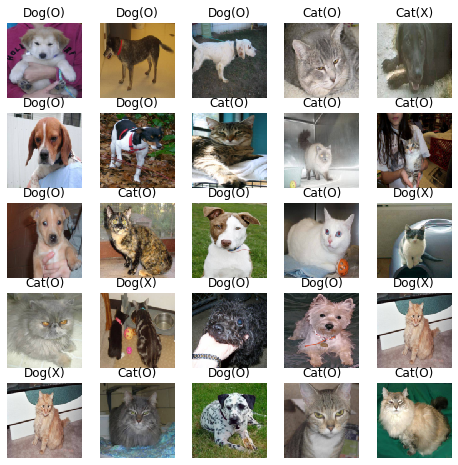

In [26]:
## 시각화

columns = 5
rows = 5
fig = plt.figure(figsize=(8,8))

model.eval()
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]
for i in range(1, columns*rows+1):
    data_idx = np.random.randint(len(test_data))
    input_img = test_data[data_idx][0].unsqueeze(dim=0).to(device) 
    output = model(input_img)
    _, argmax = torch.max(output, 1)
    pred = argmax.item()
    label = test_data[data_idx][1]
    
    fig.add_subplot(rows, columns, i)
    pred_title = 'Cat' if pred == 0 else 'Dog'
    if pred == label:
        plt.title(pred_title + '(O)')
    else:
        plt.title(pred_title + '(X)')
    plot_img = test_data[data_idx][0]
    plot_img[0, :, :] = plot_img[0, :, :] * std[0] + mean[0]
    plot_img[1, :, :] = plot_img[1, :, :] * std[1] + mean[1]
    plot_img[2, :, :] = plot_img[2, :, :] * std[2] + mean[2]
    plot_img = transforms.functional.to_pil_image(plot_img)
    plt.imshow(plot_img)
    plt.axis('off')
plt.show()